In [2]:
# Import the required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import os
%matplotlib inline

In [3]:
# Set the path to the data
path = os.getcwd()
image_path = os.path.join(path, 'CameraRGB/')
seg_path = os.path.join(path, 'CameraSeg/')
image_names = os.listdir(image_path)
seg_names = os.listdir(seg_path)

images = []
segmentations = []

# Set path to the images and segmentations
for i in range(len(image_names)):
    images.append(os.path.join(image_path, image_names[i]))
    segmentations.append(os.path.join(seg_path, seg_names[i]))


In [4]:
# Create a dataset from the images and segmentations
dataset = tf.data.Dataset.from_tensor_slices((images, segmentations))

In [5]:
# Preprocess the images and segmentations
def process_path(image_path, segment_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    seg = tf.io.read_file(segment_path)
    seg = tf.image.decode_png(seg, channels=3)
    seg = tf.math.reduce_max(seg, axis=-1, keepdims=True)
    return img, seg

def preprocess(image, seg):
    input_image = tf.image.resize(image, (96, 128), method='nearest')
    input_mask = tf.image.resize(seg, (96, 128), method='nearest')
    input_image = input_image / 255.0

    return input_image, input_mask

# Process the images and segmentations
image_ds = dataset.map(process_path)
processed_image_ds = image_ds.map(preprocess)

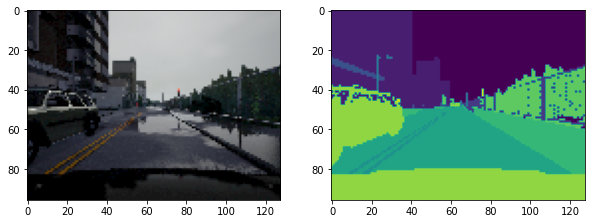

In [6]:
# Print the first 1 image and segmentation
for image, seg in processed_image_ds.take(1):
    plt.figure(figsize=(10, 10))
    plt.subplot(1, 2, 1)
    plt.imshow(image*255.0)
    plt.subplot(1, 2, 2)
    plt.imshow(seg[:, :, 0])

In [7]:
# Define the convolutional block
def conv_block(inputs=None, n_filters=32, dropout_prob=0, max_pooling=True):
    """
    Convolutional downsampling block
    
    Arguments:
        inputs -- Input tensor
        n_filters -- Number of filters for the convolutional layers
        dropout_prob -- Dropout probability
        max_pooling -- Use MaxPooling2D to reduce the spatial dimensions of the output volume
    Returns: 
        next_layer, skip_connection --  Next layer and skip connection outputs
    """
    x = keras.layers.Conv2D(n_filters, 3, padding='same',kernel_initializer = keras.initializers.HeNormal(),activation='relu')(inputs)
    x = keras.layers.Conv2D(n_filters,3, padding='same',kernel_initializer = keras.initializers.HeNormal(),activation='relu')(x)
    if dropout_prob > 0:
        x = keras.layers.Dropout(dropout_prob)(x)
    if max_pooling:
        skip_connection = x
        next_layer = keras.layers.MaxPooling2D(2,strides=2)(x)
    else:
        next_layer = x
        skip_connection = x
    return next_layer, skip_connection

In [8]:
# Define the upsampling block
def upsample_block(previous_input,skip_input,n_filters=32):
    x = keras.layers.Conv2DTranspose(n_filters, 3, strides=2, padding='same',kernel_initializer= keras.initializers.he_normal)(previous_input)
    merged = keras.layers.concatenate([x, skip_input], axis=3)
    merged = keras.layers.Conv2D(n_filters, 3, padding='same',kernel_initializer = keras.initializers.HeNormal(),activation='relu')(merged)
    merged = keras.layers.Conv2D(n_filters, 3, padding='same',kernel_initializer = keras.initializers.HeNormal(),activation='relu')(merged)
    return merged


In [9]:
# Define the model
def unet_model(input_size=(96, 128, 3), n_filters=32,n_classes=23 ):
    input = keras.layers.Input(input_size)
    conv_block1 = conv_block(inputs=input, n_filters=n_filters*1, dropout_prob=0.0, max_pooling=True)
    conv_block2 = conv_block(inputs=conv_block1[0], n_filters=n_filters*2, dropout_prob=0.0, max_pooling=True)
    conv_block3 = conv_block(inputs=conv_block2[0], n_filters=n_filters*4, dropout_prob=0.0, max_pooling=True)
    conv_block4 = conv_block(inputs=conv_block3[0], n_filters=n_filters*8, dropout_prob=0.3, max_pooling=True)
    conv_block5 = conv_block(inputs=conv_block4[0], n_filters=n_filters*16, dropout_prob=0.3, max_pooling=False)
    unsample_block1 = upsample_block(previous_input=conv_block5[0], skip_input=conv_block4[1], n_filters=n_filters*8)
    unsample_block2 = upsample_block(previous_input=unsample_block1, skip_input=conv_block3[1], n_filters=n_filters*4)
    unsample_block3 = upsample_block(previous_input=unsample_block2, skip_input=conv_block2[1], n_filters=n_filters*2)
    unsample_block4 = upsample_block(previous_input=unsample_block3, skip_input=conv_block1[1], n_filters=n_filters*1)
    conv = keras.layers.Conv2D(n_filters, 3, padding='same',kernel_initializer = keras.initializers.HeNormal(),activation='relu')(unsample_block4)
    final_conv = keras.layers.Conv2D(n_classes, 1, padding='same',kernel_initializer = keras.initializers.HeNormal())(conv)
    model = keras.models.Model(inputs=input, outputs=final_conv)
    return model

In [10]:
# Create the model
model = unet_model(input_size=(96, 128, 3), n_filters=32,n_classes=23)

In [11]:
# Check the model summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 96, 128, 3)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d (Conv2D)                (None, 96, 128, 32)  896         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 96, 128, 32)  9248        ['conv2d[0][0]']                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 48, 64, 32)   0           ['conv2d_1[0][0]']           

In [12]:
# Compile the model
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

In [13]:
# Define a function to display the results
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

(96, 128, 1)


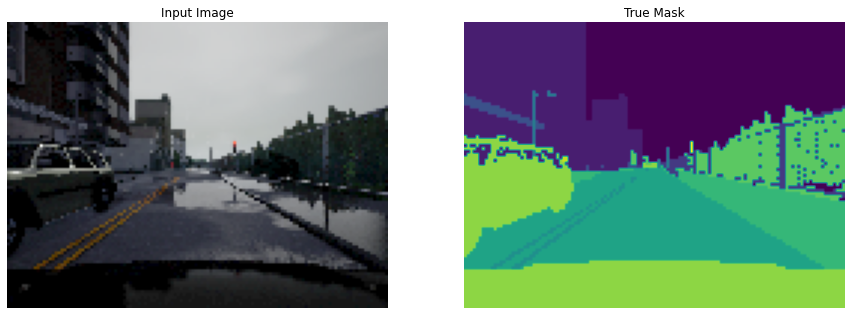

In [14]:
# Test to display the results
for image, mask in processed_image_ds.take(1):
    sample_image, sample_mask = image, mask
    print(mask.shape)
display([sample_image, sample_mask])

In [15]:
EPOCHS = 40
BUFFER_SIZE = 500
BATCH_SIZE = 32
processed_image_ds.batch(BATCH_SIZE)
train_dataset = processed_image_ds.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
model_history = model.fit(train_dataset, epochs=EPOCHS)

Epoch 1/40
32/32 [==============================] - 51s 562ms/step - loss: 2.9660 - accuracy: 0.2290
Epoch 2/40
32/32 [==============================] - 8s 235ms/step - loss: 2.0322 - accuracy: 0.3022
Epoch 3/40
32/32 [==============================] - 7s 230ms/step - loss: 1.8513 - accuracy: 0.3194
Epoch 4/40
32/32 [==============================] - 7s 231ms/step - loss: 1.5739 - accuracy: 0.4167
Epoch 5/40
32/32 [==============================] - 7s 233ms/step - loss: 1.1069 - accuracy: 0.5685
Epoch 6/40
32/32 [==============================] - 7s 233ms/step - loss: 0.9289 - accuracy: 0.6728
Epoch 7/40
32/32 [==============================] - 8s 236ms/step - loss: 0.7905 - accuracy: 0.7204
Epoch 8/40
32/32 [==============================] - 7s 230ms/step - loss: 0.7065 - accuracy: 0.7485
Epoch 9/40
32/32 [==============================] - 7s 230ms/step - loss: 0.6310 - accuracy: 0.7785
Epoch 10/40
32/32 [==============================] - 8s 242ms/step - loss: 0.5975 - accuracy: 0.784

In [16]:
# Define a function to create a segmentation mask
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

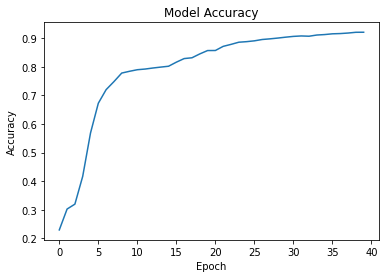

In [17]:
# Plot the results
plt.plot(model_history.history["accuracy"])
plt.title("Model Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.show()

In [18]:
# Show the predictions
def show_predictions(dataset=None, num=1):
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        sample_image, sample_mask = processed_image_ds.take(1)
        display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

In [19]:
# Save the model
model.save('segmentation_unet.h5')

1/1 [==============================] - 1s 1s/step


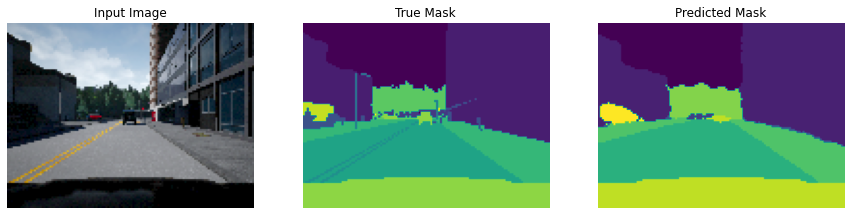

1/1 [==============================] - 0s 35ms/step


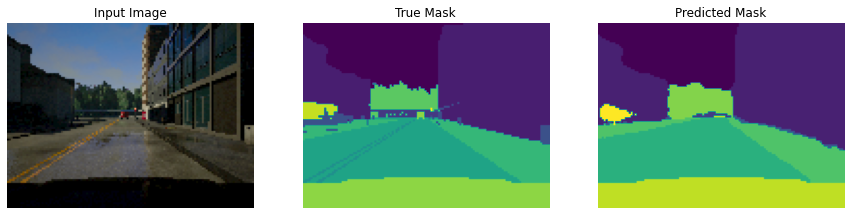

1/1 [==============================] - 0s 138ms/step


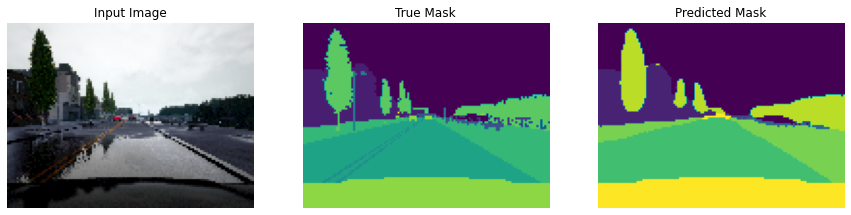

1/1 [==============================] - 0s 42ms/step


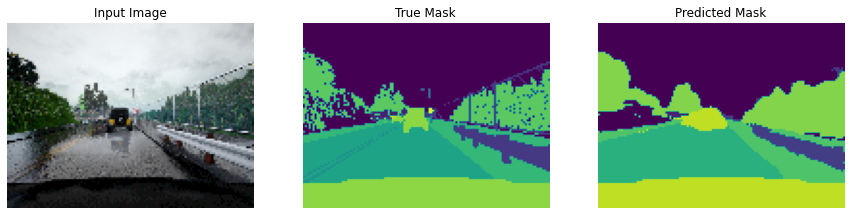

1/1 [==============================] - 0s 36ms/step


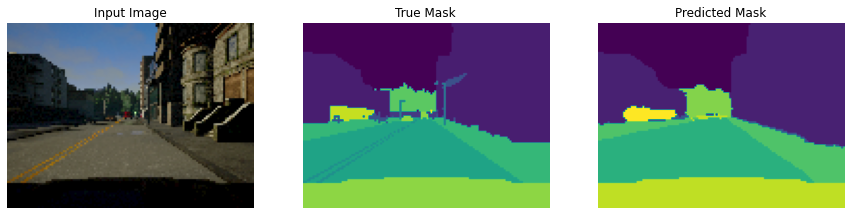

1/1 [==============================] - 0s 39ms/step


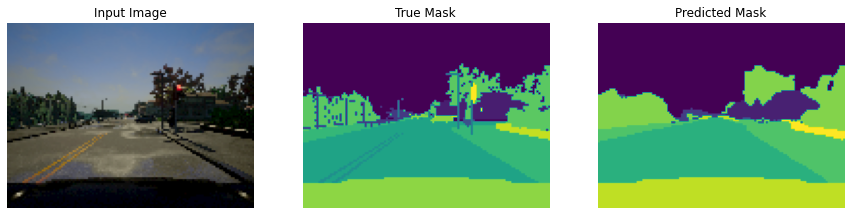

In [20]:
# Show the predictions
show_predictions(train_dataset, 6)